In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
f1 = "../data/blogData_train.csv"
f2 = "../data/modified/blogData_test.csv"
train = pd.read_csv(f1, names=["V"+str(x) if x != 281 else "y" for x in range(1, 282)])
test = pd.read_csv(f2, names=["V"+str(x) if x != 281 else "y" for x in range(1, 282)])

In [3]:
combined = train.append(test,ignore_index=True)

In [4]:
remove_col = [65,73,74,76,80,81,84,85,87,90,91,92,94,95,97,98,\
              109,111,113,123,124,126,130,132,133,148,149,155,\
              156,161,166,167,169,172,173,178,179,190,198,199,\
              200,204,209,212,217,223,224,236,243,244,250,256,262]

In [5]:
for c in remove_col:
    train = train.drop("V"+str(c), axis=1)
    test = test.drop("V"+str(c), axis=1)

In [6]:
train["y"] = np.log(train["y"]+1)
test["y"] = np.log(test["y"]+1)

In [7]:
cols = set(range(63, 263)) - set(remove_col)
cols = ["V"+str(x) for x in cols]

In [8]:
def isFreq(tp):
    p = 0.4
    all_appear = combined[tp[0]] > 0
    for word in tp[1:]:
        all_appear = all_appear & (combined[word] > 0)
    all_appear_cnt = all_appear.sum()
    for word in tp:
        word_cnt = combined[word].sum()
        if all_appear_cnt < p*word_cnt:
            return False
    return True

# Achar pares de palavras que aparecem frequentmente juntas

In [9]:
freq_word_pat = []

for i in range(len(cols)-1):
    word_i = cols[i]
    for j in range(i+1, len(cols)):
        word_j = cols[j]
        if isFreq((word_i, word_j)):
            freq_word_pat.append((word_i, word_j))

# Padrão antes do Crescimento

In [10]:
freq_n_tp = freq_word_pat
while len(freq_n_tp) > 1:
    freq_np1_tp = []
    n = len(freq_n_tp[0])
    for i in range(len(freq_n_tp)):
        common_pat = freq_n_tp[i][:(n-1)]
        for j in range(i+1,len(freq_n_tp)):
            if freq_n_tp[j][:(n-1)] != common_pat:
                break
            elif (freq_n_tp[i][1:]+freq_n_tp[j][-1:]) not in freq_n_tp:
                continue
            else:
                potential_tp = freq_n_tp[i] + freq_n_tp[j][-1:]
                if isFreq(potential_tp):
                    freq_np1_tp.append(potential_tp)
    freq_word_pat += freq_np1_tp
    freq_n_tp = freq_np1_tp

# Drop de padrões frequentes que aparecem apenas no train ou no test dataset

In [11]:
to_remove = []
for tp in freq_word_pat:
    test_exist = test[tp[0]] > 0
    for col in tp[1:]:
        test_exist = test_exist & (test[col] > 0)
    test_cnt = test_exist.sum()
    if test_cnt == .0:
        to_remove.append(tp)
        continue
    train_exist = train[tp[0]] > 0
    for col in tp[1:]:
        train_exist = train_exist & (train[col] > 0)
    train_cnt = train_exist.sum()
    if train_cnt == .0:
        freq_word_pat.remove(tp)

# Geração de feature

In [12]:
for tp in freq_word_pat:
    colname = '_'.join(tp)
    train_exist = train[tp[0]] > 0
    for col in tp[1:]:
        train_exist = train_exist & (train[col] > 0)
    train[colname] = train_exist.astype(float)
    test_exist = test[tp[0]] > 0
    for col in tp[1:]:
        test_exist = test_exist & (test[col] > 0)
    test[colname] = test_exist.astype(float)

In [13]:
train.to_csv("../data/modified/addFeatureTrain.csv", index=False)
test.to_csv("../data/modified/addFeatureTest.csv", index=False)

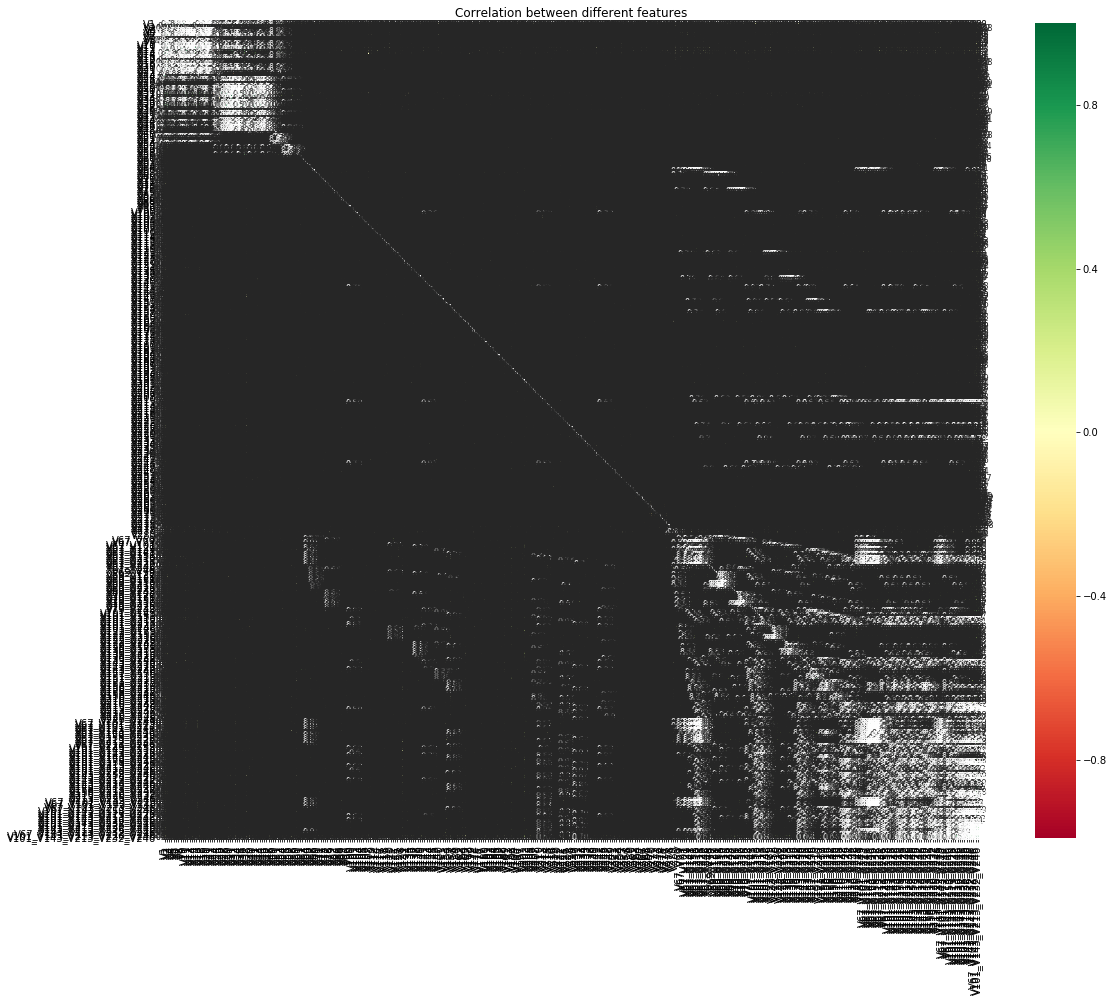

In [14]:
correlation = train.corr()
plt.figure(figsize=(20,15))
g = sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='RdYlGn',xticklabels=True,yticklabels=True, annot_kws={"size":8})


# g.set_yticklabels(g.get_yticklabels(), rotation =0)
# g.set_xticklabels(g.get_yticklabels(), size=7, rotation =90)
plt.title('Correlation between different features')
plt.show()